In [1]:
import os, sys; sys.path.append('../utils')
import pandas as pd
import numpy as np

#from graph_prep import GraphDataset
#from train_graphs import get_vector, make_like_batch, train, CV_eval

from polymerlearn.utils import GraphDataset, get_vector, make_like_batch, train, CV_eval

data = pd.read_csv(os.path.join('/home/sai/Eastman_Project/CombinedData', 
            'combined_data_clean.csv'))

mw_vector = get_vector(data, prop = 'Mw (PS)').to_numpy()
an_vector = get_vector(data, prop = 'AN').to_numpy()
ohn_vector = get_vector(data, prop = 'OHN').to_numpy()
tmp_vector = get_vector(data, prop = '%TMP', fill_value=0).to_numpy()

add = np.stack([mw_vector, an_vector, ohn_vector, tmp_vector]).T

dataset = GraphDataset(data = data, Y_target=['IV'], test_size = 0.15, add_features = add)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


/home/sai/anaconda3/envs/eastman/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
# Advanced pooling methods

import torch
import torch_geometric as pyg
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, Sequential, global_max_pool, global_mean_pool, BatchNorm
from torch_geometric.nn import SAGPooling, Set2Set, GlobalAttention

class GNNSophPool(torch.nn.Module):
    def __init__(self, input_feat, hidden_channels, num_additional = 0):
        super(GNNSophPool, self).__init__()
        self.hidden_channels = hidden_channels

        self.sage = Sequential('x, edge_index, batch', [
            (GATConv(input_feat, hidden_channels, aggr = 'max'), 'x, edge_index -> x'),
            BatchNorm(hidden_channels, track_running_stats=False),
            torch.nn.PReLU(),
            (SAGEConv(hidden_channels, hidden_channels, aggr = 'max'), 'x, edge_index -> x'),
            BatchNorm(hidden_channels, track_running_stats=False),
            torch.nn.PReLU(),
            (SAGPooling(hidden_channels), 'x, edge_index, batch=batch -> x'),
        ])

        self.fc1 = torch.nn.Linear(hidden_channels * 2 + num_additional, hidden_channels)
        self.leaky1 = torch.nn.PReLU()
        self.fc2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, Abatch: torch.Tensor, Gbatch: torch.Tensor, add_features: torch.Tensor):
        '''
        
        '''
        # Decompose X into acid and glycol

        Aembeddings = self.sage(Abatch.x, Abatch.edge_index, Abatch.batch)[0]
        Gembeddings = self.sage(Gbatch.x, Gbatch.edge_index, Gbatch.batch)[0]
        
        Aembed, _ = torch.max(Aembeddings, dim=0)
        Gembed, _ = torch.max(Gembeddings, dim=0)

        # Aggregate pooled vectors
        if add_features is not None:
            poolAgg = torch.cat([Aembed, Gembed, add_features])
        else:
            poolAgg = torch.cat([Aembed, Gembed])

        x = self.leaky1(self.fc1(poolAgg))
        x = self.fc2(x)

        # Because we're predicting log:
        return torch.exp(x)

In [4]:
model_generator_kwargs = {
    'input_feat': 7,
    'hidden_channels': 32,
    'num_additional': 4,
}

optimizer_gen = torch.optim.AdamW
criterion = torch.nn.MSELoss()

all_predictions, all_y, all_inds = CV_eval(
    dataset = dataset,
    model_generator = GNNSophPool,
    optimizer_generator = optimizer_gen,
    criterion = criterion,
    model_generator_kwargs = model_generator_kwargs,
    optimizer_kwargs = {'lr': 0.0001, 'weight_decay':1e-4},
    epochs = 800,
    batch_size = 64,
    verbose = 1,
    )

../utils/graph_prep.py:381: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272097173/work/torch/csrc/utils/tensor_new.cpp:201.)
  return self.test_data, torch.tensor(self.Ytest).float(), self.add_test, test_inds


Fold: 1 	 Epoch: 0, 	 Train r2: -1.5175 	 Train Loss: 5.2950


KeyboardInterrupt: 

In [4]:
# Identify outliers:

all_predictions = np.array(all_predictions)
all_y = np.array(all_y)
all_inds = np.array(all_inds)

error_vec = np.abs(all_predictions - all_y)
most_errors = np.argsort(error_vec)

print('5 largest errors:', error_vec[most_errors][-5:])

# Sort by args:
inds = all_inds[most_errors]

data_trim = data.loc[data['IV'].notna(),:]

df_err = data_trim.iloc[inds[-5:],:].copy()

df_err['Abs_error'] = error_vec[most_errors][-5:]

df_err.to_csv('error5_iv.csv', index = False)

print('Largest')
print('Indices:', inds[-5:])
print(df_err)

# print(all_y)
# print(dataset.Y)

#errors = [all_y[i] - dataset.Y[all_inds[i]] for i in range(len(all_y))]
#print(errors)

5 largest errors: [0.36981702 0.3710379  0.44531775 0.45163223 0.79303956]
Largest
Indices: [284 161 230 223 275]
    Resin# Reactor Reaction Solvent    AN        OHN OHN (primary)  \
340    C63     NaN              NaN   NaN        NaN           NaN   
211    213     Rig             Neat  2.67  11.570767           NaN   
286     C9     NaN              NaN   NaN        NaN           NaN   
279     C2     NaN              NaN   NaN        NaN           NaN   
331    C54     NaN              NaN   NaN        NaN           NaN   

    OHN (secondary)     IV  IV - Intrinsic    Tg  ...  %NPG  %1,4-CHDM  \
340             NaN  0.548             NaN -46.0  ...   NaN        NaN   
211             NaN  0.823           0.872   NaN  ...   NaN       43.1   
286             NaN  0.645             NaN  21.0  ...   NaN        NaN   
279             NaN  0.840             NaN  45.0  ...   NaN        NaN   
331             NaN  1.600             NaN  -3.0  ...   NaN        NaN   

     %1,3-CHDM  %TMC

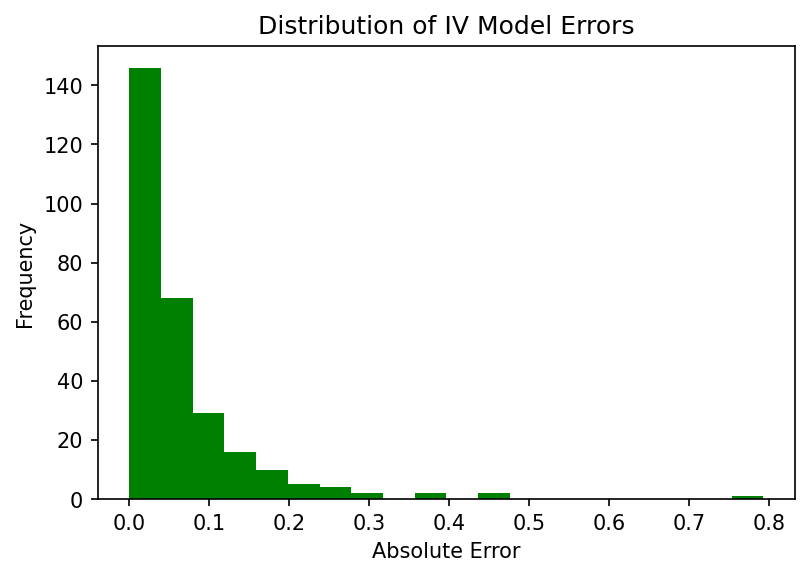

In [5]:
import matplotlib.pyplot as plt

error = np.abs(np.array(all_predictions) - np.array(all_y))
error = np.sort(error)

plt.figure(dpi=150)
plt.hist(error, bins = 20, color = 'green')
plt.title('Distribution of IV Model Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()

Number over 0.3, 6


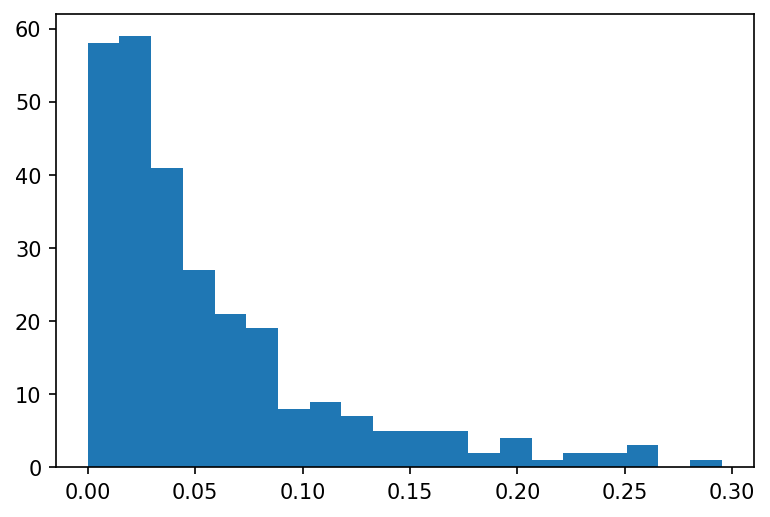

In [6]:
# Find samples with largest error:
mask = (error < 0.3)
masked_error = error[mask]

print('Number over 0.3, {}'.format(np.sum((error > 0.3))))

plt.figure(dpi=150)
plt.hist(masked_error, bins = 20)
plt.show()

In [7]:
masky = np.array(all_y)[mask]
maskpred = np.array(all_predictions)[mask]

print(r2_score(masky, maskpred))

NameError: name 'r2_score' is not defined

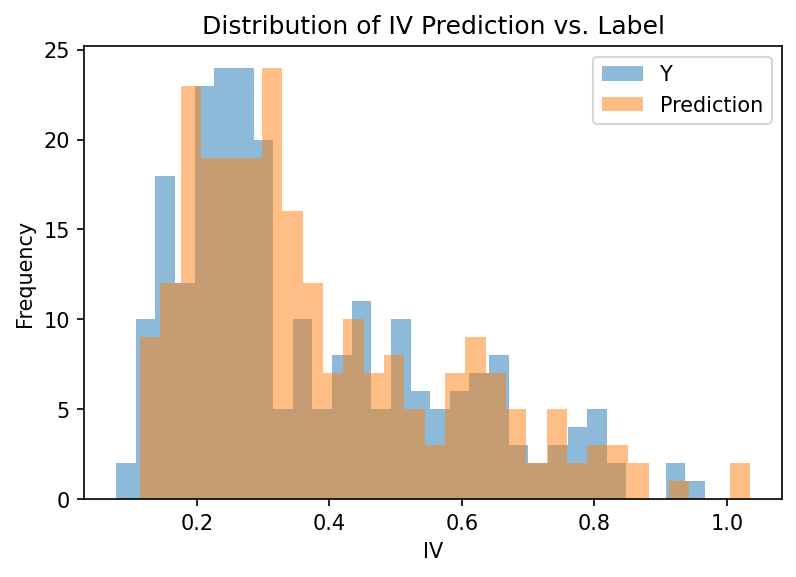

In [ ]:
plt.figure(dpi=150)
plt.hist(all_y, alpha = 0.5, bins = 30, label = 'Y')
plt.hist(all_predictions, alpha = 0.5, bins = 30, label = 'Prediction')
plt.legend()
plt.title('Distribution of IV Prediction vs. Label')
plt.xlabel('IV')
plt.ylabel('Frequency')
plt.show()

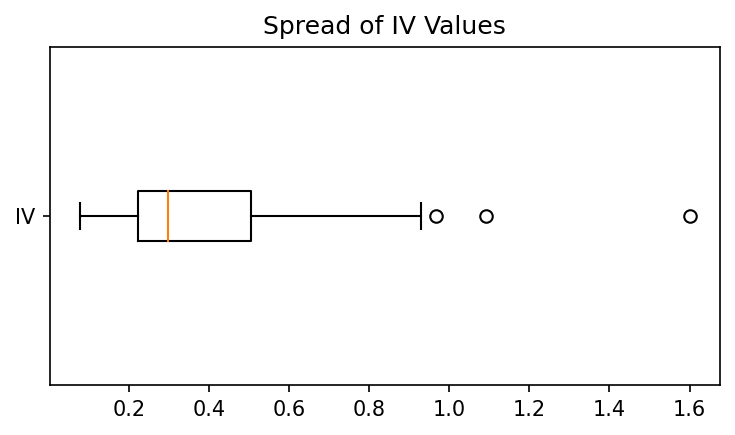

In [ ]:
plt.figure(dpi=150, figsize = [5, 3])
plt.boxplot(all_y, vert = False)
plt.yticks(ticks = [1], labels = ['IV'])
plt.title('Spread of IV Values')
plt.tight_layout()
plt.show()

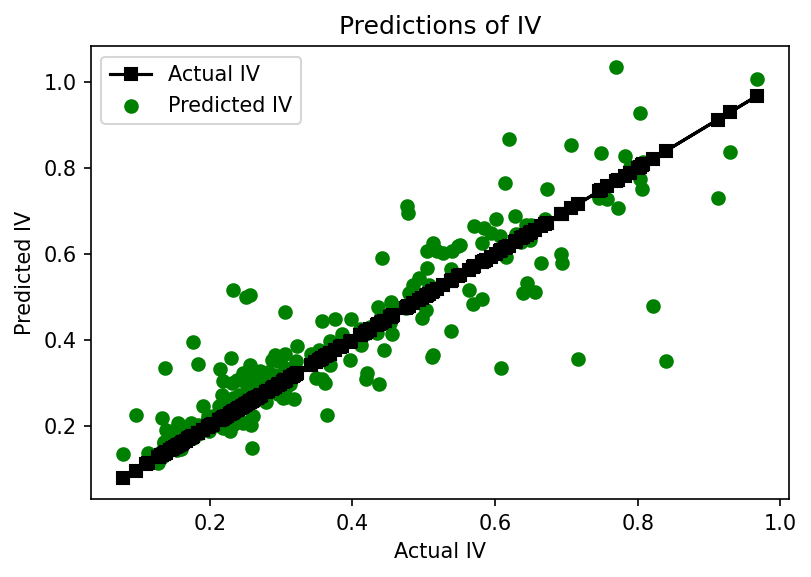

In [ ]:
# Predicted vs. Actual plot
plt.figure(dpi=150)
plt.plot(all_y, all_y, marker = 's', c = 'black', label = 'Actual IV')
plt.scatter(all_y, all_predictions, c = 'green', label = 'Predicted IV')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.title('Predictions of IV')
plt.legend()
plt.show()